In [1]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf

/Users/YoYoYe/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


In [2]:
valid_set_size_percentage = 10 
test_set_size_percentage = 10 

oil_df = pd.read_csv("us_crude_oil.csv")
oil_df = oil_df.iloc[::-1].reset_index(drop=True)
oil_df.head()

,Date,US Production,US Import,US Exports,US Net Import,Inventory,Adjustment,Import from OPEC,Crude Oil and Liquid Fuels Supply,OPEC Production Capacity,Net Inventory Withdrawals,OPEC Production,Value,Nominal
0,1/31/94,6816779.0,5945000,110000,5835290.0,338067000.0,733963.032,2892000,9454972.161,27959177.0,-658883.053,24493494.87,24.80,14.48
1,2/28/94,6770326.0,6313000,116000,6197498.0,335351000.0,77211.714,3237000,9313861.429,27959177.0,2352418.325,24477904.76,25.25,14.79
2,3/31/94,6745622.0,6372000,41000,6331468.0,342345000.0,242361.355,3006000,9380460.548,27959177.0,880568.964,24520851.10,28.80,16.90
3,4/30/94,6612102.0,6955000,120000,6835867.0,339391000.0,302264.000,3728000,9303302.667,27959177.0,-734538.343,24370063.76,31.18,18.31
4,5/31/94,6688193.0,7198000,118000,7080258.0,331544000.0,259904.258,3771000,9339128.968,27959177.0,-2706335.628,24513404.04,32.89,19.37


In [3]:
oil_df.columns

Index(['Date', 'US Production', 'US Import', 'US Exports', 'US Net Import',
       'Inventory', 'Adjustment', 'Import from OPEC',
       'Crude Oil and Liquid Fuels Supply', 'OPEC Production Capacity',
       'Net Inventory Withdrawals', 'OPEC Production', 'Value', 'Nominal'],
      dtype='object')

In [4]:
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['US Production'] = min_max_scaler.fit_transform(df['US Production'].values.reshape(-1,1))
    df['US Import'] = min_max_scaler.fit_transform(df['US Import'].values.reshape(-1,1))
    df['US Exports'] = min_max_scaler.fit_transform(df['US Exports'].values.reshape(-1,1))
    #df['US Net Import'] = min_max_scaler.fit_transform(df['US Net Import'].values.reshape(-1,1))
    df['Inventory'] = min_max_scaler.fit_transform(df['Inventory'].values.reshape(-1,1))
    #df['Adjustment'] = min_max_scaler.fit_transform(df['Adjustment'].values.reshape(-1,1))
    #df['Import from OPEC'] = min_max_scaler.fit_transform(df['Import from OPEC'].values.reshape(-1,1))
    #df['Crude Oil and Liquid Fuels Supply'] = min_max_scaler.fit_transform(df['Crude Oil and Liquid Fuels Supply'].values.reshape(-1,1))
    #df['OPEC Production Capacity'] = min_max_scaler.fit_transform(df['OPEC Production Capacity'].values.reshape(-1,1))
    #df['Net Inventory Withdrawals'] = min_max_scaler.fit_transform(df['Net Inventory Withdrawals'].values.reshape(-1,1))
    df['OPEC Production'] = min_max_scaler.fit_transform(df['OPEC Production'].values.reshape(-1,1))
    df['Value'] = min_max_scaler.fit_transform(df['Value'].values.reshape(-1,1))
    return df

In [5]:
def load_data(stock, seq_len):
    data_raw = stock.as_matrix() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    X_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    X_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    X_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [X_train, y_train, X_valid, y_valid, X_test, y_test]

In [6]:
oil_data = oil_df[["US Production","US Import","US Exports","Inventory","OPEC Production","Value"]]
#oil_data.drop(['Date'],1,inplace=True)
#oil_data.drop(['Nominal'],1,inplace=True)

cols = list(oil_data.columns.values)
print('oil_data.columns.values = ', cols)

oil_data.columns.values =  ['US Production', 'US Import', 'US Exports', 'Inventory', 'OPEC Production', 'Value']


In [7]:
oil_norm = oil_data.copy()
oil_norm = normalize_data(oil_norm)
oil_norm.head()

/Users/YoYoYe/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


,US Production,US Import,US Exports,Inventory,OPEC Production,Value
0,0.365184,0.000000,0.046472,0.257859,0.027736,0.053020
1,0.359217,0.076349,0.049053,0.247807,0.025941,0.056156
2,0.356044,0.088589,0.016781,0.273692,0.030887,0.080889
3,0.338895,0.209544,0.050775,0.262759,0.013520,0.097471
4,0.348668,0.259959,0.049914,0.233718,0.030029,0.109385


In [8]:
# create train, test data
seq_len = 20 # choose sequence length

X_train, y_train, X_valid, y_valid, X_test, y_test = load_data(oil_norm, seq_len)
print('x_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',X_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (223, 19, 6)
y_train.shape =  (223, 6)
x_valid.shape =  (28, 19, 6)
y_valid.shape =  (28, 6)
x_test.shape =  (28, 19, 6)
y_test.shape =  (28, 6)


/Users/YoYoYe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [9]:
index_in_epoch = 0;
perm_array  = np.arange(X_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, X_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > X_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return X_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters
n_steps = seq_len-1 
n_inputs = 6
n_neurons = 200 
n_outputs = 6
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100 
train_set_size = X_train.shape[0]
test_set_size = X_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

In [10]:
# use Basic RNN Cell
layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]

multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


In [11]:
# run graph
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: X_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: X_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: X_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: X_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: X_test})

0.00 epochs: MSE train/valid = 0.369615/0.540920
4.93 epochs: MSE train/valid = 0.008490/0.050859
9.87 epochs: MSE train/valid = 0.004806/0.035043
14.80 epochs: MSE train/valid = 0.003872/0.021436
19.73 epochs: MSE train/valid = 0.003299/0.021016
24.66 epochs: MSE train/valid = 0.002891/0.017837
29.60 epochs: MSE train/valid = 0.002705/0.016120
34.53 epochs: MSE train/valid = 0.002415/0.013544
39.46 epochs: MSE train/valid = 0.002280/0.013223
44.39 epochs: MSE train/valid = 0.002328/0.011176
49.33 epochs: MSE train/valid = 0.002229/0.010483
54.26 epochs: MSE train/valid = 0.001991/0.009944
59.19 epochs: MSE train/valid = 0.002002/0.011378
64.13 epochs: MSE train/valid = 0.001893/0.010023
69.06 epochs: MSE train/valid = 0.001755/0.008887
73.99 epochs: MSE train/valid = 0.001732/0.008207
78.92 epochs: MSE train/valid = 0.001610/0.008373
83.86 epochs: MSE train/valid = 0.001583/0.007859
88.79 epochs: MSE train/valid = 0.001567/0.007710
93.72 epochs: MSE train/valid = 0.001462/0.007237
98.

In [12]:
y_train.shape

(223, 6)

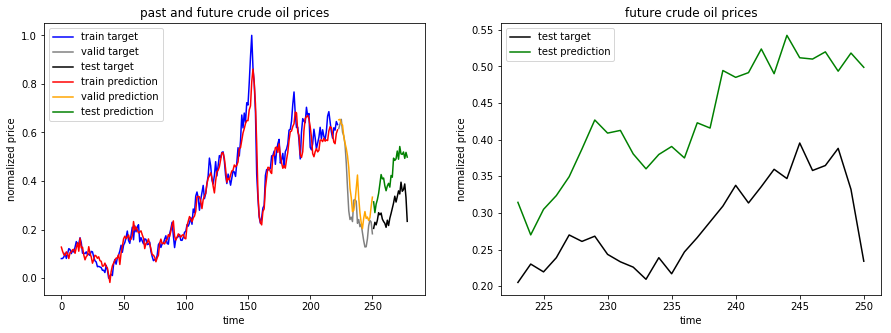

In [18]:
ft = 5 # for oil price

## show predictions
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='orange', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('past and future crude oil prices')
plt.xlabel('time')
plt.ylabel('normalized price')
plt.legend(loc='best');

plt.subplot(1,2,2);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('future crude oil prices')
plt.xlabel('time')
plt.ylabel('normalized price')
plt.legend(loc='best')

plt.savefig("RNN_6feature.png")